# Churn prediction using logistic regression

<a id='table'></a>
## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#explor">Data Exploration</a></li>
<li><a href="#dummy_var">Creating dummy variables</a></li>
<li><a href="#smote">Over-sampling using SMOTEÂ¶</a></li>   
<li><a href="#rfe">Recursive Feature EliminationÂ¶</a></li> 
<li><a href="#impl">Implementing the modelÂ¶</a></li>   
<li><a href="#fitting">Logistic Regression Model FittingÂ¶</a></li>
<li><a href="#cm">Confusion Matrix</a></li>
<li><a href="#summary">Summary</a></li>
<li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

Customer **churn**, also known as customer attrition, occurs when customers stop doing business with a company. The companies are interested in identifying segments of these customers because the price for acquiring a new customer is usually higher than retaining the old one. For example, if Netflix knew a segment of customers who were at risk of churning they could proactively engage them with special offers instead of simply losing them.

**Logistic Regression** is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

### Motivation

I was curious to apply logistic regression to predict customer churn.

### Data

In this notebook, a customer churn prediction model is built using Telco Customer Churn [dataset](https://www.kaggle.com/blastchar/telco-customer-churn).

**Input variables**:

1. customerID - Customer ID
2. gender - Whether the customer is a male or a female
3. SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)
4. Partner - Whether the customer has a partner or not (Yes, No)
5. Dependents - Whether the customer has dependents or not (Yes, No)
6. tenure - Number of months the customer has stayed with the company
7. PhoneService - Whether the customer has a phone service or not (Yes, No)
8. MultipleLines - Whether the customer has multiple lines or not (Yes, No, No phone service)
9. InternetService - Customerâ€™s internet service provider (DSL, Fiber optic, No)
10. OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)
11. OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
12. DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)
13. TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)
14. StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)
15. StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)
16. Contract - The contract term of the customer (Month-to-month, One year, Two year)
17. PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
18. PaymentMethod - The customerâ€™s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
19. MonthlyCharges - The amount charged to the customer monthly
20. TotalCharges - The total amount charged to the customer

**Predict varibale**:
Churn - Whether the customer churned or not (Yes or No)

In [113]:
# Import necessary packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font")
%matplotlib inline

In [114]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

**Some data quality issues:**
* TotalCharges is in object format, which should be change to float;
* For exploratory data analysis it would be useful to change all boolean values from 'Yes', 'No' to 1 and 0, respectively
* I got "ValueError: Unable to parse string " " at position 48"", when I tried to change the data format from object to float. It seems there some rows with "" value, which I decided to remove.

In [116]:
total_charges_filter = df.TotalCharges == " "
df = df[~total_charges_filter]
df.TotalCharges = pd.to_numeric(df.TotalCharges);

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
# Let's change the data type for TotalCharge
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], downcast="float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float32
Churn               7032 non-null object
dtypes: float32(1), float64(1), 

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
# Let's check duplicated values in the dataset
sum(df.duplicated())

0

In [119]:
# Let us copy a dataframe for analytics
df_copy = df.copy()

In [120]:
df_copy['Churn'].loc[df_copy.Churn == 'Yes'] = 1
df_copy['Churn'].loc[df_copy.Churn == 'No'] = 0
df_copy['Partner'].loc[df_copy.Partner == 'Yes'] = 1
df_copy['Partner'].loc[df_copy.Partner == 'No'] = 0
df_copy['Dependents'].loc[df_copy.Dependents == 'Yes'] = 1
df_copy['Dependents'].loc[df_copy.Dependents == 'No'] = 0
df_copy['PhoneService'].loc[df_copy.PhoneService == 'Yes'] = 1
df_copy['PhoneService'].loc[df_copy.PhoneService == 'No'] = 0
df_copy['PaperlessBilling'].loc[df_copy.PaperlessBilling == 'Yes'] = 1
df_copy['PaperlessBilling'].loc[df_copy.PaperlessBilling == 'No'] = 0

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [121]:
df_copy.describe()

SeniorCitizen      Partner   Dependents       tenure  PhoneService  \
count    7032.000000  7032.000000  7032.000000  7032.000000   7032.000000   
mean        0.162400     0.482509     0.298493    32.421786      0.903299   
std         0.368844     0.499729     0.457629    24.545260      0.295571   
min         0.000000     0.000000     0.000000     1.000000      0.000000   
25%         0.000000     0.000000     0.000000     9.000000      1.000000   
50%         0.000000     0.000000     0.000000    29.000000      1.000000   
75%         0.000000     1.000000     1.000000    55.000000      1.000000   
max         1.000000     1.000000     1.000000    72.000000      1.000000   

       PaperlessBilling  MonthlyCharges  TotalCharges        Churn  
count       7032.000000     7032.000000   7032.000000  7032.000000  
mean           0.592719       64.798208   2283.298340     0.265785  
std            0.491363       30.085974   2266.770508     0.441782  
min            0.000000       18.250000     18.799999     0.000000  
25%            0.000000       35.587500    401.449997     0.000000  
50%            1.000000       70.350000   1397.475037     0.000000  
75%            1.000000       89.862500   3794.737488     1.000000  
max            1.000000      118.750000   8684.799805     1.000000

<a id='explor'></a>
## Data Exploration

In [122]:
df_copy['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

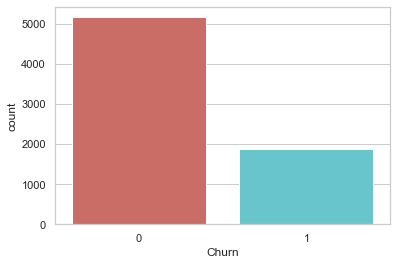

In [123]:
sns.countplot(x='Churn', data=df_copy, palette='hls')
plt.show()

In [124]:
count_no_churn = len(df_copy[df_copy['Churn']==0])
count_churn = len(df_copy[df_copy['Churn']==1])
pct_of_no_churn = count_no_churn/(len(df_copy))
print("Percentage of costumers didn't churn:", pct_of_no_churn*100)
pct_of_churn = count_churn/(len(df_copy))
print("Percentage of customers who churn:", pct_of_churn*100)

Percentage of costumers didn't churn: 73.42150170648463
Percentage of customers who churn: 26.578498293515356


It's clear that we have a disproportion between users who did't churn and churn. Before we go ahead to balance the classes, letâ€™s do some more exploration.

In [125]:
df_copy.groupby('Churn').mean()

SeniorCitizen   Partner  Dependents     tenure  PhoneService  \
Churn                                                                 
0           0.128995  0.527600    0.343405  37.650010      0.901220   
1           0.254682  0.357945    0.174425  17.979133      0.909042   

       PaperlessBilling  MonthlyCharges  TotalCharges  
Churn                                                  
0              0.536122       61.307408   2555.344238  
1              0.749064       74.441332   1531.796143

Looking at the table, we can say that customers who churn:
* Are older than who decided to have a subscribtion
* Stayed less months with the company
* Had a higher monthly charge
* May don't have a partner
* May don't have dependents
* Got less total charges, than those who stayed with the service

It seems that the availability of the phone service does not influence much.

In [126]:
df_copy.groupby('gender').mean()

SeniorCitizen   Partner  Dependents     tenure  PhoneService  \
gender                                                                 
Female       0.163078  0.483204    0.293712  32.290841      0.905541   
Male         0.161736  0.481826    0.303184  32.550296      0.901099   

        PaperlessBilling  MonthlyCharges  TotalCharges     Churn  
gender                                                            
Female          0.598622       65.216652   2283.190918  0.269595  
Male            0.586926       64.387546   2283.407959  0.262046

If we group by a gender, we do not get any significant difference between the parameters, particularly, for the average churn rate.

In [127]:
df_copy.groupby('SeniorCitizen').mean()

Partner  Dependents     tenure  PhoneService  \
SeniorCitizen                                                  
0              0.478778    0.340917  32.252292      0.902207   
1              0.501751    0.079685  33.295972      0.908932   

               PaperlessBilling  MonthlyCharges  TotalCharges     Churn  
SeniorCitizen                                                            
0                      0.558913       61.885594   2181.089600  0.236503  
1                      0.767075       79.820359   2810.465088  0.416813

Apart from having a higher churn rate among senior sitizens, senior sitizens may have higher monthly and total charges for the service and less dependents. Also, senior citizens have higher paperless billing.

In [128]:
df_copy.groupby('Partner').mean()

SeniorCitizen  Dependents     tenure  PhoneService  PaperlessBilling  \
Partner                                                                         
0             0.156362    0.098653  23.370706      0.898049          0.599340   
1             0.168877    0.512821  42.129089      0.908930          0.585617   

         MonthlyCharges  TotalCharges     Churn  
Partner                                          
0             61.956472   1584.960449  0.329761  
1             67.845977   3032.271729  0.197171

It's interesting that, even though customers without a partner on average had a lower monthly charge, they have a higher churn rate than those who have a partner. Also, customers without a partner have a lower number of dependents. The lower number of total charges can be explained by less time being subscribed to the service.

In [129]:
df_copy.groupby('PaymentMethod').mean()

SeniorCitizen   Partner  Dependents     tenure  \
PaymentMethod                                                               
Bank transfer (automatic)       0.151102  0.587549    0.343709  43.713359   
Credit card (automatic)         0.145299  0.560815    0.351742  43.297830   
Electronic check                0.251163  0.424101    0.202537  25.174630   
Mailed check                    0.058603  0.393392    0.346010  21.938903   

                           PhoneService  PaperlessBilling  MonthlyCharges  \
PaymentMethod                                                               
Bank transfer (automatic)      0.907912          0.576524       67.205577   
Credit card (automatic)        0.899408          0.579882       66.519264   
Electronic check               0.904440          0.736575       76.255814   
Mailed check                   0.900873          0.408354       43.958354   

                           TotalCharges     Churn  
PaymentMethod                                      
Bank transfer (automatic)   3079.299561  0.167315  
Credit card (automatic)     3071.395996  0.152531  
Electronic check            2090.868164  0.452854  
Mailed check                1054.483887  0.192020

There is a significant difference in a churn rate for customers who use electronic check. Maybe the company can think more about how to improve the billing process and increse retention rate among the group of customers.

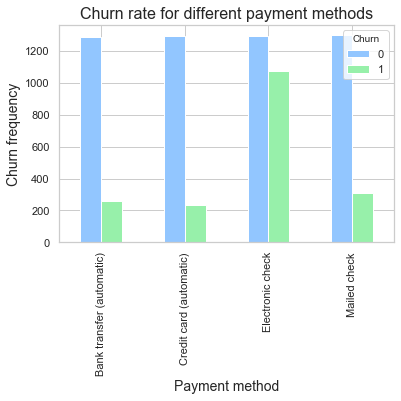

In [130]:
# Bar chart for differentpayment methods and their churn rates
plt.style.use('seaborn-pastel')
pd.crosstab(df_copy['PaymentMethod'], df_copy['Churn']).plot(kind='bar')
plt.title('Churn rate for different payment methods', fontsize=16)
plt.xlabel('Payment method', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

In [131]:
df_copy.groupby('PaperlessBilling').mean()

SeniorCitizen   Partner  Dependents     tenure  \
PaperlessBilling                                                   
0                      0.092877  0.490922    0.359288  32.278980   
1                      0.210173  0.476727    0.256718  32.519914   

                  PhoneService  MonthlyCharges  TotalCharges     Churn  
PaperlessBilling                                                        
0                     0.897346       52.025960   1851.738525  0.163757  
1                     0.907390       73.574532   2579.843994  0.335893

It's interesting that paperless billing has a higher churn rate.

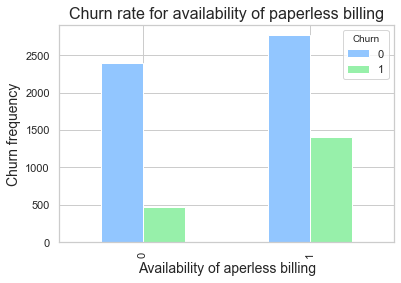

In [132]:
# Bar chart for paperless billing and its churn rates
plt.style.use('seaborn-pastel')
pd.crosstab(df_copy['PaperlessBilling'], df_copy['Churn']).plot(kind='bar')
plt.title('Churn rate for availability of paperless billing', fontsize=16)
plt.xlabel('Availability of aperless billing', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

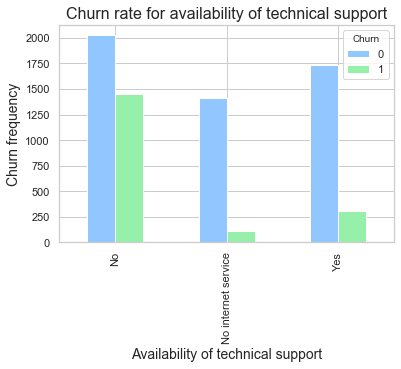

In [133]:
# Bar chart for technical support and its churn rates
plt.style.use('seaborn-pastel')
pd.crosstab(df_copy['TechSupport'], df_copy['Churn']).plot(kind='bar')
plt.title('Churn rate for availability of technical support', fontsize=16)
plt.xlabel('Availability of technical support', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

It's clear that customers who get technical support less tend to unsubscribe from the service and opposite for customers who have technical support.

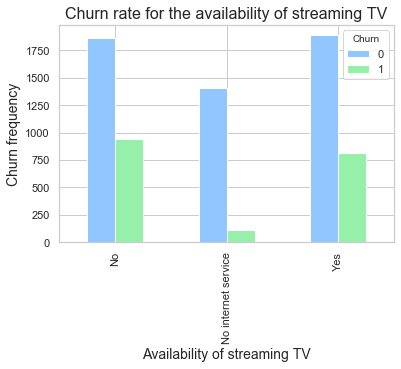

In [134]:
# Bar chart for streaming TV and its churn rates
plt.style.use('seaborn-pastel')
pd.crosstab(df_copy['StreamingTV'], df_copy['Churn']).plot(kind='bar')
plt.title('Churn rate for the availability of streaming TV', fontsize=16)
plt.xlabel('Availability of streaming TV', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

Customers who have streaming TV less tend to churn than those who do not have it. However, the least churn rate belongs to a group without internet service.

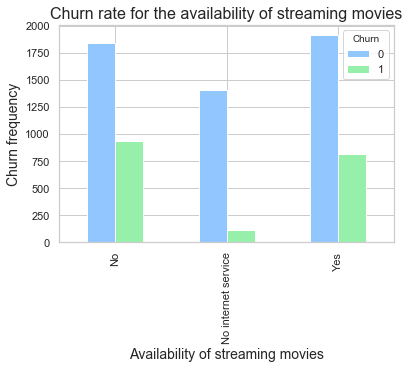

In [135]:
# Bar chart for streaming movies and its churn rates
plt.style.use('seaborn-pastel')
pd.crosstab(df_copy['StreamingMovies'], df_copy['Churn']).plot(kind='bar')
plt.title('Churn rate for the availability of streaming movies', fontsize=16)
plt.xlabel('Availability of streaming movies', fontsize=14)
plt.ylabel('Churn frequency', fontsize=14);

The bar chart replicates previous one for streaming TV. 

In [136]:
# Checking the number of customers with streaming movies
df_copy.StreamingMovies.value_counts()

No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64

In [137]:
# Checking the number of customers with streaming TV
df_copy.StreamingTV.value_counts()

No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64

We can see that the values vary insignificanltly for streaming movies and TV categories.

<a id='dummy_var'></a>
## Creating dummy variables

That is variables with only two values, zero and one

In [138]:
# Converting boolean variables to a format for further use
df['Churn'].loc[df.Churn == 'Yes'] = 1;
df['Churn'].loc[df.Churn == 'No'] = 0;
df['SeniorCitizen'].loc[df.SeniorCitizen == 1] = 'Yes';
df['SeniorCitizen'].loc[df.SeniorCitizen == 0] = 'No';

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [139]:
df.head()

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female            No     Yes         No       1           No   
1  5575-GNVDE    Male            No      No         No      34          Yes   
2  3668-QPYBK    Male            No      No         No       2          Yes   
3  7795-CFOCW    Male            No      No         No      45           No   
4  9237-HQITU  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85     29.850000      0  
1               Mailed check          56.95   1889.500000      0  
2               Mailed check          53.85    108.150002      1  
3  Bank transfer (automatic)          42.30   1840.750000      0  
4           Electronic check          70.70    151.649994      1  

[5 rows x 21 columns]

In [140]:
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',\
            'PhoneService', 'MultipleLines', 'InternetService',\
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',\
            'PaperlessBilling', 'PaymentMethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    df=df1

cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',\
            'PhoneService', 'MultipleLines', 'InternetService',\
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',\
            'PaperlessBilling', 'PaymentMethod']
df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]
df_final=df[to_keep]
df_final.columns.values

array(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'SeniorCitizen_No',
       'SeniorCitizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_Month-

In [141]:
# Looking at the dataset with dummy variables
df_final.head()

customerID  tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0  7590-VHVEG       1           29.85     29.850000      0              1   
1  5575-GNVDE      34           56.95   1889.500000      0              0   
2  3668-QPYBK       2           53.85    108.150002      1              0   
3  7795-CFOCW      45           42.30   1840.750000      0              0   
4  9237-HQITU       2           70.70    151.649994      1              1   

   gender_Male  SeniorCitizen_No  SeniorCitizen_Yes  Partner_No  ...  \
0            0                 1                  0           0  ...   
1            1                 1                  0           1  ...   
2            1                 1                  0           1  ...   
3            1                 1                  0           1  ...   
4            0                 1                  0           1  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   
1                    0                        0                  1   
2                    0                        1                  0   
3                    0                        0                  1   
4                    0                        1                  0   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0                  0                    0                     1   
1                  0                    1                     0   
2                  0                    0                     1   
3                  0                    1                     0   
4                  0                    0                     1   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 48 columns]

In [142]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 48 columns):
customerID                                 7032 non-null object
tenure                                     7032 non-null int64
MonthlyCharges                             7032 non-null float64
TotalCharges                               7032 non-null float32
Churn                                      7032 non-null int64
gender_Female                              7032 non-null uint8
gender_Male                                7032 non-null uint8
SeniorCitizen_No                           7032 non-null uint8
SeniorCitizen_Yes                          7032 non-null uint8
Partner_No                                 7032 non-null uint8
Partner_Yes                                7032 non-null uint8
Dependents_No                              7032 non-null uint8
Dependents_Yes                             7032 non-null uint8
PhoneService_No                            7032 non-null uint8
PhoneS

In [143]:
# Dropping out customerID column
df_final.drop(['customerID'], axis=1, inplace=True)
df_final.head()

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  gender_Male  \
0       1           29.85     29.850000      0              1            0   
1      34           56.95   1889.500000      0              0            1   
2       2           53.85    108.150002      1              0            1   
3      45           42.30   1840.750000      0              0            1   
4       2           70.70    151.649994      1              1            0   

   SeniorCitizen_No  SeniorCitizen_Yes  Partner_No  Partner_Yes  ...  \
0                 1                  0           0            1  ...   
1                 1                  0           1            0  ...   
2                 1                  0           1            0  ...   
3                 1                  0           1            0  ...   
4                 1                  0           1            0  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   
1                    0                        0                  1   
2                    0                        1                  0   
3                    0                        0                  1   
4                    0                        1                  0   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0                  0                    0                     1   
1                  0                    1                     0   
2                  0                    0                     1   
3                  0                    1                     0   
4                  0                    0                     1   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 47 columns]

<a id='smote'></a>
## Over-sampling using SMOTEÂ¶

SMOTE algorithm (Synthetic Minority Oversampling Technique) is used to up-sample no-churn. Overall, SMOTE:
* Works by creating synthetic samples from the minor class (no-churn) instead of creating copies;
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [144]:
X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

In [145]:
X

tenure  MonthlyCharges  TotalCharges  gender_Female  gender_Male  \
0          1           29.85     29.850000              1            0   
1         34           56.95   1889.500000              0            1   
2          2           53.85    108.150002              0            1   
3         45           42.30   1840.750000              0            1   
4          2           70.70    151.649994              1            0   
...      ...             ...           ...            ...          ...   
7038      24           84.80   1990.500000              0            1   
7039      72          103.20   7362.899902              1            0   
7040      11           29.60    346.450012              1            0   
7041       4           74.40    306.600006              0            1   
7042      66          105.65   6844.500000              0            1   

      SeniorCitizen_No  SeniorCitizen_Yes  Partner_No  Partner_Yes  \
0                    1                  0           0            1   
1                    1                  0           1            0   
2                    1                  0           1            0   
3                    1                  0           1            0   
4                    1                  0           1            0   
...                ...                ...         ...          ...   
7038                 1                  0           0            1   
7039                 1                  0           0            1   
7040                 1                  0           0            1   
7041                 0                  1           0            1   
7042                 1                  0           1            0   

      Dependents_No  ...  StreamingMovies_Yes  Contract_Month-to-month  \
0                 1  ...                    0                        1   
1                 1  ...                    0                        0   
2                 1  ...                    0                        1   
3                 1  ...                    0                        0   
4                 1  ...                    0                        1   
...             ...  ...                  ...                      ...   
7038              0  ...                    1                        0   
7039              0  ...                    1                        0   
7040              0  ...                    0                        1   
7041              1  ...                    0                        1   
7042              1  ...                    1                        0   

      Contract_One year  Contract_Two year  PaperlessBilling_No  \
0                     0                  0                    0   
1                     1                  0                    1   
2                     0                  0                    0   
3                     1                  0                    1   
4                     0                  0                    0   
...                 ...                ...                  ...   
7038                  1                  0                    0   
7039                  1                  0                    0   
7040                  0                  0                    0   
7041                  0                  0                    0   
7042                  0                  1                    0   

      PaperlessBilling_Yes  PaymentMethod_Bank transfer (automatic)  \
0                        1                                        0   
1                        0                                        0   
2                        1                                        0   
3                        0                                        1   
4                        1                                        0   
...                    ...                                      ...   
7038                     1                                        0   
7039          

In [146]:
y

Churn
0         0
1         0
2         1
3         0
4         1
...     ...
7038      0
7039      0
7040      0
7041      1
7042      0

[7032 rows x 1 columns]

In [147]:
# Splitting the dataset to train and test
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [148]:
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Churn'])

In [149]:
# Checking the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of NO churn in oversampled data:",len(os_data_y[os_data_y['Churn']==0]))
print("Number of churn:",len(os_data_y[os_data_y['Churn']==1]))
print("Proportion of NO churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']==0])/len(os_data_X))
print("Proportion of churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']==1])/len(os_data_X))

Length of oversampled data is  7216
Number of NO churn in oversampled data: 3608
Number of churn: 3608
Proportion of NO churn data in oversampled data is  0.5
Proportion of churn data in oversampled data is  0.5


Now we have perfectly balanced data! ðŸ˜Š 
It should be noted that only on the training data was oversampled, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations. It means no information will intrude from test data into the model training.

<a id='rfe'></a>
## Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [150]:
df_final_vars=df_final.columns.values.tolist()
y=['Churn']
X=[i for i in df_final_vars if i not in y]

In [151]:
# Getting RFE results
logregress = LogisticRegression(max_iter=2000);

rfe = RFE(logregress, 20);
rfe = rfe.fit(os_data_X, os_data_y.values.ravel());
print(rfe.support_);
print(rfe.ranking_);

[False False False  True  True  True  True  True  True  True  True False
 False  True  True  True False False False False False False False False
 False False False False False False False False False False False  True
 False False  True  True  True  True  True  True  True  True]
[24 25 27  1  1  1  1  1  1  1  1 22 26  1  1  1 23 14 11 13  4 12  3 16
  2  8  7  9  6 10  5 17 15 18 19  1 20 21  1  1  1  1  1  1  1  1]


In [152]:
# Showing features selected by RFE
ranking = rfe.support_
df_r = pd.DataFrame(ranking)
df_x = df_final.copy()
df_x.drop(['Churn'], axis=1, inplace=True)
columns_x = df_x.columns.values
df_col = pd.DataFrame(columns_x)
df_ranking = df_col.merge(df_r, left_index=True, right_index=True, how='inner')
df_features = df_ranking.loc[df_ranking['0_y'] == True]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 3 to 45
Data columns (total 2 columns):
0_x    20 non-null object
0_y    20 non-null bool
dtypes: bool(1), object(1)
memory usage: 340.0+ bytes


In [153]:
# Selecting only parameters for the model
df_features

0_x   0_y
3                             gender_Female  True
4                               gender_Male  True
5                          SeniorCitizen_No  True
6                         SeniorCitizen_Yes  True
7                                Partner_No  True
8                               Partner_Yes  True
9                             Dependents_No  True
10                           Dependents_Yes  True
13                         MultipleLines_No  True
14           MultipleLines_No phone service  True
15                        MultipleLines_Yes  True
35      StreamingMovies_No internet service  True
38                        Contract_One year  True
39                        Contract_Two year  True
40                      PaperlessBilling_No  True
41                     PaperlessBilling_Yes  True
42  PaymentMethod_Bank transfer (automatic)  True
43    PaymentMethod_Credit card (automatic)  True
44           PaymentMethod_Electronic check  True
45               PaymentMethod_Mailed check  True

**Recursive Feature Elimination (RFE) has helped us select the following 20 important features:** gender_Female, gender_Male, SeniorCitizen_No, SeniorCitizen_Yes, Partner_No, Partner_Yes, Dependents_No, Dependents_Yes, MultipleLines_No, MultipleLines_No phone service, MultipleLines_Yes, StreamingMovies_No internet service, Contract_One year, Contract_Two year, PaperlessBilling_No, PaperlessBilling_Yes, PaymentMethod_Bank transfer (automatic), PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check.

In [154]:
# Selecting necessary columns
cols=["gender_Female", "gender_Male", "SeniorCitizen_No", "SeniorCitizen_Yes",\
      "Partner_No", "Partner_Yes", "Dependents_No", "Dependents_Yes",\
      "MultipleLines_No", "MultipleLines_No phone service", "MultipleLines_Yes",\
      "StreamingMovies_No internet service", "Contract_One year", "Contract_Two year",\
      "PaperlessBilling_No", "PaperlessBilling_Yes", "PaymentMethod_Bank transfer (automatic)",\
      "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check"] 
X=os_data_X[cols]
y=os_data_y["Churn"]

<a id='impl'></a>
## Implementing the model

In [155]:
# Getting summary on logistic regression model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.464619
         Iterations 7
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.330    
Dependent Variable:         Churn                    AIC:                      6745.3849
Date:                       2020-04-28 15:08         BIC:                      6883.0660
No. Observations:           7216                     Log-Likelihood:           -3352.7  
Df Model:                   19                       LL-Null:                  -5001.8  
Df Residuals:               7196                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             7.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef

The **p-values** for most of the variables are smaller than 0.05, except four variables, therefore, we will remove them.

In [156]:
cols=["gender_Female", "gender_Male", "SeniorCitizen_No", "SeniorCitizen_Yes",\
     "Partner_Yes", "Dependents_No","MultipleLines_No", "MultipleLines_Yes",\
      "StreamingMovies_No internet service", "Contract_One year", "Contract_Two year",\
      "PaperlessBilling_Yes", "PaymentMethod_Bank transfer (automatic)",\
      "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check"]
X=os_data_X[cols]
y=os_data_y['Churn']

In [157]:
# Getting results of logistic regressing after removing parameters
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.465056
         Iterations 7
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.329    
Dependent Variable:         Churn                    AIC:                      6743.6914
Date:                       2020-04-28 15:08         BIC:                      6853.8363
No. Observations:           7216                     Log-Likelihood:           -3355.8  
Df Model:                   15                       LL-Null:                  -5001.8  
Df Residuals:               7200                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             7.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef

**p-value** for Partner_Yes became > 0.05. Therefore, we have to remove the parameter.

In [158]:
cols=["gender_Female", "gender_Male", "SeniorCitizen_No", "SeniorCitizen_Yes",\
      "Dependents_No","MultipleLines_No", "MultipleLines_Yes",\
      "StreamingMovies_No internet service", "Contract_One year", "Contract_Two year",\
      "PaperlessBilling_Yes", "PaymentMethod_Bank transfer (automatic)",\
      "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check"]
X=os_data_X[cols]
y=os_data_y['Churn']

In [159]:
# Getting final results
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.465153
         Iterations 7
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.329    
Dependent Variable:         Churn                    AIC:                      6743.0823
Date:                       2020-04-28 15:08         BIC:                      6846.3432
No. Observations:           7216                     Log-Likelihood:           -3356.5  
Df Model:                   14                       LL-Null:                  -5001.8  
Df Residuals:               7201                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             7.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef

Now all parameters have p-value less than 0.05.

<a id='fitting'></a>
## Logistic Regression Model Fitting

In [160]:
# Fitting the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logregress = LogisticRegression()
logregress.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [161]:
# Getting information on the accuracy of the model
y_pred = logregress.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregress.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


<a id='cm'></a>
## Confusion Matrix

In [162]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[869 195]
 [184 917]]


We got 869+917=1,786 correct predictions and 184+195=379 incorrect predictions.

In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1064
           1       0.82      0.83      0.83      1101

    accuracy                           0.82      2165
   macro avg       0.82      0.82      0.82      2165
weighted avg       0.82      0.82      0.82      2165



To quote from Scikit Learn:
* The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
* The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
* The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
* The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
* The **support** is the number of occurrences of each class in y_test.

It's interesting that the logistic regression has quite high precision, recall, f1-score and accuracy values (0.82).

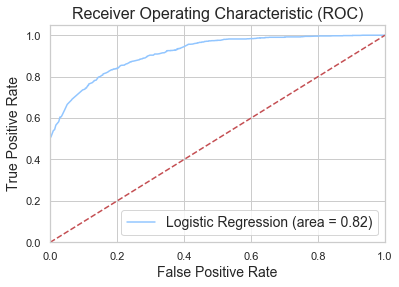

In [165]:
# Building ROC curve
logit_roc_auc = roc_auc_score(y_test, logregress.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregress.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('Log_ROC', fontsize=14)
plt.show();

The **receiver operating characteristic (ROC)** curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away from that line as possible (toward the top-left corner).

<a id='summary'></a>
## Summary

* This logistic regression model can predict churn with 0.82 accuracy, which can help to retain old users;
* We got 1,786 correct predictions and 379 incorrect predictions of churn;
* In order to implement the model, Synthetic Minority Oversampling Technique (SMOT) and Recursive Feature Elimination (RFE) were applied to balance the data and select the important features; 
* After apllying RFE, we chose parameters with p-value less than 0.05. Overall, the model was implemented using the following parameters: "gender_Female", "gender_Male", "SeniorCitizen_No", "SeniorCitizen_Yes", "Dependents_No","MultipleLines_No", "MultipleLines_Yes", "StreamingMovies_No internet service", "Contract_One year", "Contract_Two year", "PaperlessBilling_Yes", "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check", "PaymentMethod_Mailed check".

<a id='ref'></a>
## References

1. [An Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/)
2. [Churn prediction](https://towardsdatascience.com/churn-prediction-770d6cb582a5)
3. [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
4. [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
5. [Feature Selection in Python â€” Recursive Feature Elimination](https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15)
6. [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)
7. [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) 

Go to <a href="#table">Table of Contents</a>